<a href="https://colab.research.google.com/github/cloverbunny/mimic-iv/blob/master/c14_combine_mimic_files3_20_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning mimic files so far into one notebook

Notes from Notebook on how to run bigquery in colab - https://github.com/MIT-LCP/mimic-code/discussions/1154

Load libraries and connect to the data

Run the following cells to import some libraries and then connect to the database.

In [1]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [11]:
auth.authenticate_user()

In [3]:
project_id='prismatic-fact-272817'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id


Getting intubated patients who stayed in MICU units

[BigQuery syntax](https://googleapis.dev/python/bigquery/latest/magics.html).

In [22]:
%%bigquery vented

select v.stay_id
from `physionet-data.mimic_derived.ventilation` v join  `physionet-data.mimic_icu.icustays` icus on v.stay_id = icus.stay_id
where ventilation_status like 'InvasiveVent'
AND
  first_careunit LIKE '%MICU%'
  AND last_careunit LIKE '%MICU%'
group by v.stay_id

In [23]:
vented.shape

(7254, 1)

In [24]:
vented_unique = vented.drop_duplicates(subset=["stay_id"])

In [25]:
vented_unique.shape

(7254, 1)

## Questions

- What does `patientunitstayid` represent? (hint, see: http://eicu-crd.mit.edu/eicutables/patient/)
- What does `patienthealthsystemstayid` represent?
- What does `uniquepid` represent?

In [6]:
# select a limited number of columns to view
columns = ['uniquepid', 'patientunitstayid','gender','age','unitdischargestatus']
patient[columns].head()

,uniquepid,patientunitstayid,gender,age,unitdischargestatus
0,002-10665,210014,Male,45,Alive
1,002-10715,200026,Male,50,Alive
2,002-10249,221131,Male,83,Alive
3,002-10627,221215,Male,49,Alive
4,002-10324,217835,Male,57,Alive


- Try running the following query, which lists unique values in the age column. What do you notice?

In [7]:
# what are the unique values for age?
age_col = 'age'
patient[age_col].sort_values().unique()

array(['', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69',
       '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80',
       '81', '82', '83', '84', '85', '86', '87', '88', '89', '> 89'],
      dtype=object)

- Try plotting a histogram of ages using the command in the cell below. What happens? Why?

In [8]:
# try plotting a histogram of ages
patient[age_col].plot(kind='hist', bins=15)

TypeError: ignored

Let's create a new column named `age_num`, then try again.

In [9]:
# create a column containing numerical ages
# If ‘coerce’, then invalid parsing will be set as NaN
agenum_col = 'age_num'
patient[agenum_col] = pd.to_numeric(patient[age_col], errors='coerce')
patient[agenum_col].sort_values().unique()

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
       55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
       68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80.,
       81., 82., 83., 84., 85., 86., 87., 88., 89., nan])

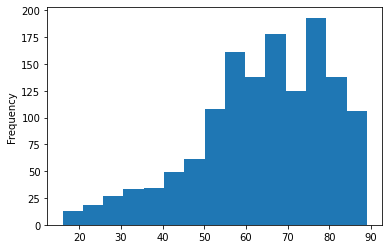

In [10]:
patient[agenum_col].plot(kind='hist', bins=15)

## Questions

- Use the `mean()` method to find the average age. Why do we expect this to be lower than the true mean?
- In the same way that you use `mean()`, you can use `describe()`, `max()`, and `min()`. Look at the admission heights (`admissionheight`) of patients in cm. What issue do you see? How can you deal with this issue?

In [ ]:
adheight_col = 'admissionheight'
patient[adheight_col].describe()

In [ ]:
# set threshold
adheight_col = 'admissionheight'
patient[patient[adheight_col] < 10] = None